# Twi N-gram Language Model

This notebook implements an n-gram language model for **Twi** (a low-resource Ghanaian language).

**Features:**
- Whitespace tokenization (appropriate for Twi)
- Validation set tuning for smoothing parameter k
- Perplexity evaluation on held-out test set
- Autocomplete functionality

Adapted from Coursera NLP Specialization Course 2, Week 3.

## 1. Setup and Imports

In [1]:
import os
import math
from collections import defaultdict
import matplotlib.pyplot as plt

# Configuration
DATA_DIR = "data"
RESULTS_DIR = "results"
TRAIN_FILE = os.path.join(DATA_DIR, "train.twi")
VAL_FILE = os.path.join(DATA_DIR, "val.twi")
TEST_FILE = os.path.join(DATA_DIR, "test.twi")
MIN_FREQ = 2  # Minimum word frequency for vocabulary

os.makedirs(RESULTS_DIR, exist_ok=True)
print("Setup complete!")

Setup complete!


## 2. Data Loading and Preprocessing Functions

In [2]:
def load_data(filepath):
    """Load text data from file (one sentence per line)."""
    with open(filepath, 'r', encoding='utf-8') as f:
        data = f.read()
    return data


def split_to_sentences(data):
    """Split data by newline."""
    sentences = data.split('\n')
    sentences = [s.strip() for s in sentences]
    sentences = [s for s in sentences if len(s) > 0]
    return sentences


def tokenize_sentences(sentences):
    """
    Tokenize sentences using whitespace splitting.
    More appropriate for Twi than NLTK's English tokenizer.
    """
    tokenized_sentences = []
    for sentence in sentences:
        tokens = sentence.lower().split()
        if tokens:
            tokenized_sentences.append(tokens)
    return tokenized_sentences


def get_tokenized_data(data):
    """Split data into sentences and tokenize."""
    sentences = split_to_sentences(data)
    tokenized_sentences = tokenize_sentences(sentences)
    return tokenized_sentences


def count_words(tokenized_sentences):
    """Count word frequencies."""
    word_counts = defaultdict(int)
    for sentence in tokenized_sentences:
        for token in sentence:
            word_counts[token] += 1
    return dict(word_counts)


def get_words_with_nplus_frequency(tokenized_sentences, count_threshold):
    """Get words appearing at least count_threshold times."""
    word_counts = count_words(tokenized_sentences)
    closed_vocab = [word for word, cnt in word_counts.items() if cnt >= count_threshold]
    return closed_vocab


def replace_oov_words_by_unk(tokenized_sentences, vocabulary, unknown_token="<unk>"):
    """Replace out-of-vocabulary words with <unk>."""
    vocabulary = set(vocabulary)
    replaced = []
    for sentence in tokenized_sentences:
        replaced_sentence = [token if token in vocabulary else unknown_token for token in sentence]
        replaced.append(replaced_sentence)
    return replaced


def preprocess_data(train_data, test_data, count_threshold, val_data=None, unknown_token="<unk>"):
    """
    Preprocess train, validation, and test data:
    1. Build vocabulary from training data
    2. Replace OOV words with <unk>
    """
    vocabulary = get_words_with_nplus_frequency(train_data, count_threshold)
    train_data_replaced = replace_oov_words_by_unk(train_data, vocabulary, unknown_token)
    test_data_replaced = replace_oov_words_by_unk(test_data, vocabulary, unknown_token)
    
    if val_data is not None:
        val_data_replaced = replace_oov_words_by_unk(val_data, vocabulary, unknown_token)
        return train_data_replaced, val_data_replaced, test_data_replaced, vocabulary
    
    return train_data_replaced, test_data_replaced, vocabulary

print("Preprocessing functions defined!")

Preprocessing functions defined!


## 3. N-gram Model Functions

In [3]:
def count_n_grams(data, n, start_token='<s>', end_token='<e>'):
    """Count all n-grams in the data."""
    n_grams = defaultdict(int)
    
    for sentence in data:
        sentence = [start_token] * n + sentence + [end_token]
        sentence = tuple(sentence)
        
        for i in range(len(sentence) - n + 1):
            n_gram = sentence[i:i+n]
            n_grams[n_gram] += 1
    
    return dict(n_grams)


def estimate_probability(word, previous_n_gram, n_gram_counts, n_plus1_gram_counts, 
                         vocabulary_size, k=1.0):
    """
    Estimate probability of word given previous n-gram using k-smoothing.
    
    P(word | previous_n_gram) = (C(previous_n_gram, word) + k) / (C(previous_n_gram) + k*V)
    """
    previous_n_gram = tuple(previous_n_gram)
    previous_n_gram_count = n_gram_counts.get(previous_n_gram, 0)
    denominator = previous_n_gram_count + (k * vocabulary_size)
    
    n_plus1_gram = previous_n_gram + (word,)
    n_plus1_gram_count = n_plus1_gram_counts.get(n_plus1_gram, 0)
    numerator = n_plus1_gram_count + k
    
    probability = numerator / denominator
    return probability


def estimate_probabilities(previous_n_gram, n_gram_counts, n_plus1_gram_counts, 
                          vocabulary, end_token='<e>', unknown_token="<unk>", k=1.0):
    """Estimate probabilities for all words in vocabulary."""
    previous_n_gram = tuple(previous_n_gram)
    vocab_extended = vocabulary + [end_token, unknown_token]
    vocabulary_size = len(vocab_extended)
    
    probabilities = {}
    for word in vocab_extended:
        probability = estimate_probability(word, previous_n_gram, n_gram_counts, 
                                          n_plus1_gram_counts, vocabulary_size, k=k)
        probabilities[word] = probability
    
    return probabilities

print("N-gram model functions defined!")

N-gram model functions defined!


## 4. Perplexity Evaluation Functions

In [4]:
def calculate_perplexity(sentence, n_gram_counts, n_plus1_gram_counts, 
                         vocabulary_size, start_token='<s>', end_token='<e>', k=1.0):
    """
    Calculate perplexity for a sentence.
    
    PP(W) = (∏ 1/P(w_t | w_{t-n}...w_{t-1}))^(1/N)
    """
    n = len(list(n_gram_counts.keys())[0])
    sentence = [start_token] * n + sentence + [end_token]
    sentence = tuple(sentence)
    N = len(sentence)
    
    log_prob_sum = 0.0
    
    for t in range(n, N):
        n_gram = sentence[t-n:t]
        word = sentence[t]
        
        probability = estimate_probability(word, n_gram, n_gram_counts, 
                                          n_plus1_gram_counts, vocabulary_size, k=k)
        
        log_prob_sum += math.log(probability)
    
    perplexity = math.exp(-log_prob_sum / N)
    return perplexity


def calculate_perplexity_on_corpus(test_data, n_gram_counts, n_plus1_gram_counts,
                                   vocabulary_size, k=1.0):
    """Calculate average perplexity over a corpus."""
    perplexities = []
    for sentence in test_data:
        if len(sentence) > 0:
            pp = calculate_perplexity(sentence, n_gram_counts, n_plus1_gram_counts,
                                     vocabulary_size, k=k)
            perplexities.append(pp)
    
    return sum(perplexities) / len(perplexities) if perplexities else float('inf')

print("Perplexity functions defined!")

Perplexity functions defined!


## 5. Hyperparameter Tuning

In [5]:
def tune_smoothing_parameter(train_data, val_data, vocabulary, n_values=[1, 2, 3], 
                              k_values=[0.1, 0.5, 1.0, 2.0, 5.0]):
    """
    Tune the smoothing parameter k using validation set.
    
    Returns:
        best_k: optimal smoothing parameter
        best_n: optimal n-gram order
        tuning_results: detailed results for all combinations
    """
    vocab_size = len(vocabulary) + 2  # +2 for <e> and <unk>
    tuning_results = []
    
    print(f"Tuning hyperparameters on validation set...")
    print(f"N-gram orders: {n_values}")
    print(f"K values: {k_values}")
    
    best_pp = float('inf')
    best_k = 1.0
    best_n = 1
    
    for n in n_values:
        n_gram_counts = count_n_grams(train_data, n)
        n_plus1_gram_counts = count_n_grams(train_data, n + 1)
        
        for k in k_values:
            pp = calculate_perplexity_on_corpus(
                val_data, n_gram_counts, n_plus1_gram_counts, vocab_size, k=k
            )
            tuning_results.append({'n': n, 'k': k, 'perplexity': pp})
            
            if pp < best_pp:
                best_pp = pp
                best_k = k
                best_n = n
    
    print(f"\nBest: {best_n}-gram with k={best_k} (val perplexity={best_pp:.2f})")
    
    return best_k, best_n, tuning_results

print("Tuning function defined!")

Tuning function defined!


## 6. Autocomplete Functions

In [6]:
def suggest_a_word(previous_tokens, n_gram_counts, n_plus1_gram_counts, 
                   vocabulary, k=1.0, start_with=None):
    """Suggest the most likely next word."""
    n = len(list(n_gram_counts.keys())[0])
    previous_tokens = ['<s>'] * n + previous_tokens
    previous_n_gram = previous_tokens[-n:]
    
    probabilities = estimate_probabilities(previous_n_gram, n_gram_counts, 
                                          n_plus1_gram_counts, vocabulary, k=k)
    
    suggestion = None
    max_prob = 0
    
    for word, prob in probabilities.items():
        if start_with and not word.startswith(start_with):
            continue
        if prob > max_prob:
            suggestion = word
            max_prob = prob
    
    return suggestion, max_prob


def get_top_k_suggestions(previous_tokens, n_gram_counts, n_plus1_gram_counts,
                          vocabulary, k=1.0, top_k=5):
    """Get top-k word suggestions."""
    n = len(list(n_gram_counts.keys())[0])
    previous_tokens = ['<s>'] * n + previous_tokens
    previous_n_gram = previous_tokens[-n:]
    
    probabilities = estimate_probabilities(previous_n_gram, n_gram_counts,
                                          n_plus1_gram_counts, vocabulary, k=k)
    
    sorted_probs = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)
    return sorted_probs[:top_k]

print("Autocomplete functions defined!")

Autocomplete functions defined!


## 7. Load and Preprocess Data

In [7]:
# Load data
print("Loading data...")
train_raw = load_data(TRAIN_FILE)
val_raw = load_data(VAL_FILE)
test_raw = load_data(TEST_FILE)

# Tokenize
print("Tokenizing...")
train_tokenized = get_tokenized_data(train_raw)
val_tokenized = get_tokenized_data(val_raw)
test_tokenized = get_tokenized_data(test_raw)

print(f"Training sentences: {len(train_tokenized):,}")
print(f"Validation sentences: {len(val_tokenized):,}")
print(f"Test sentences: {len(test_tokenized):,}")

Loading data...
Tokenizing...
Training sentences: 29,003
Validation sentences: 800
Test sentences: 1,300


In [8]:
# Preprocess (handle OOV)
print(f"Preprocessing (min_freq={MIN_FREQ})...")
train_data, val_data, test_data, vocabulary = preprocess_data(
    train_tokenized, test_tokenized, MIN_FREQ, val_data=val_tokenized
)
print(f"Vocabulary size: {len(vocabulary):,}")

# Calculate OOV rate
test_tokens = [t for s in test_tokenized for t in s]
oov_count = sum(1 for t in test_tokens if t not in set(vocabulary))
oov_rate = oov_count / len(test_tokens) * 100
print(f"OOV rate on test set: {oov_rate:.2f}%")

Preprocessing (min_freq=2)...
Vocabulary size: 13,194
OOV rate on test set: 2.45%


## 8. Tune Hyperparameters on Validation Set

In [9]:
# Tune k on validation set
best_k, best_n, tuning_results = tune_smoothing_parameter(
    train_data, val_data, vocabulary,
    n_values=[1, 2, 3, 4, 5],
    k_values=[0.01, 0.1, 0.5, 1.0, 2.0]
)

Tuning hyperparameters on validation set...
N-gram orders: [1, 2, 3, 4, 5]
K values: [0.01, 0.1, 0.5, 1.0, 2.0]

Best: 1-gram with k=0.01 (val perplexity=303.77)


## 9. Train and Evaluate N-gram Models

In [10]:
print(f"Evaluating on test set with tuned k={best_k}...\n")

results = []
n_gram_counts_list = []
vocab_size = len(vocabulary) + 2

for n in range(1, 6):
    print(f"Evaluating {n}-gram model...")
    n_gram_counts = count_n_grams(train_data, n)
    n_plus1_gram_counts = count_n_grams(train_data, n + 1)
    n_gram_counts_list.append((n_gram_counts, n_plus1_gram_counts))
    
    print(f"  Unique {n}-grams: {len(n_gram_counts):,}")
    
    perplexity = calculate_perplexity_on_corpus(
        test_data, n_gram_counts, n_plus1_gram_counts, vocab_size, k=best_k
    )
    
    print(f"  Perplexity: {perplexity:.2f}\n")
    results.append({'n': n, 'perplexity': perplexity, 'n_grams': len(n_gram_counts)})

Evaluating on test set with tuned k=0.01...

Evaluating 1-gram model...
  Unique 1-grams: 13,197
  Perplexity: 334.50

Evaluating 2-gram model...
  Unique 2-grams: 180,191
  Perplexity: 883.42

Evaluating 3-gram model...
  Unique 3-grams: 419,172
  Perplexity: 1640.18

Evaluating 4-gram model...
  Unique 4-grams: 539,333
  Perplexity: 1693.02

Evaluating 5-gram model...
  Unique 5-grams: 577,492
  Perplexity: 1468.79



## 10. Visualize Results

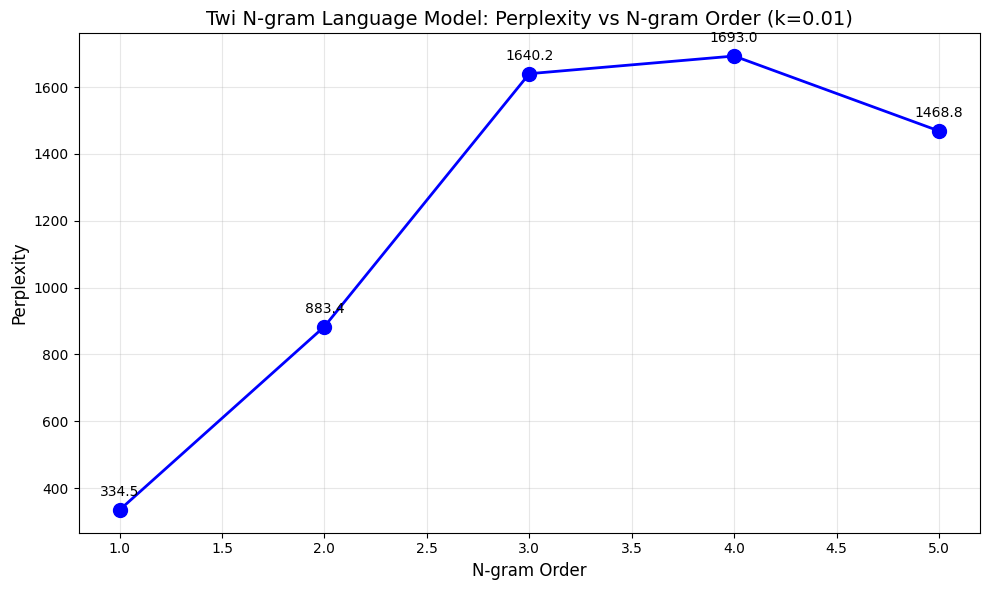

In [11]:
# Plot perplexity vs n-gram order
n_values = [r['n'] for r in results]
perplexities = [r['perplexity'] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(n_values, perplexities, 'bo-', linewidth=2, markersize=10)
plt.xlabel('N-gram Order', fontsize=12)
plt.ylabel('Perplexity', fontsize=12)
plt.title(f'Twi N-gram Language Model: Perplexity vs N-gram Order (k={best_k})', fontsize=14)
plt.grid(True, alpha=0.3)

for n, pp in zip(n_values, perplexities):
    plt.annotate(f'{pp:.1f}', (n, pp), textcoords="offset points", 
                xytext=(0, 10), ha='center')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "perplexity_plot.png"), dpi=150)
plt.show()

In [12]:
# Summary table
print("\n" + "="*50)
print("PERPLEXITY SUMMARY")
print("="*50)
print(f"Tuned smoothing parameter: k = {best_k}")
print(f"Validation sentences: {len(val_data):,}")
print("\n{:<12} {:>12} {:>15}".format('N-gram', 'Perplexity', 'Unique N-grams'))
print("-"*40)

best_test_n = min(results, key=lambda x: x['perplexity'])['n']
for r in results:
    marker = " <-- Best" if r['n'] == best_test_n else ""
    print(f"{r['n']}-gram{marker:<10} {r['perplexity']:>10.2f} {r['n_grams']:>15,}")


PERPLEXITY SUMMARY
Tuned smoothing parameter: k = 0.01
Validation sentences: 800

N-gram         Perplexity  Unique N-grams
----------------------------------------
1-gram <-- Best      334.50          13,197
2-gram               883.42         180,191
3-gram              1640.18         419,172
4-gram              1693.02         539,333
5-gram              1468.79         577,492


## 11. Autocomplete Demo

In [13]:
# Get the best model for autocomplete
best_n_gram_counts, best_n_plus1_gram_counts = n_gram_counts_list[best_test_n - 1]

# Test autocomplete with some Twi phrases
sample_inputs = [
    ["na"],                  # "and"
    ["awurade"],             # "Lord"
    ["na", "ɔka"],           # "and he said"
    ["me", "nyankopɔn"],     # "my God"
]

print("\n" + "="*50)
print("AUTOCOMPLETE DEMO")
print("="*50)

for input_tokens in sample_inputs:
    suggestions = get_top_k_suggestions(
        input_tokens, best_n_gram_counts, best_n_plus1_gram_counts,
        vocabulary, k=best_k, top_k=5
    )
    
    print(f"\nInput: '{' '.join(input_tokens)}'")
    print("Top suggestions:")
    for word, prob in suggestions:
        print(f"  - {word}: {prob:.4f}")


AUTOCOMPLETE DEMO

Input: 'na'
Top suggestions:
  - <unk>: 0.0370
  - awurade: 0.0241
  - sɛ: 0.0210
  - wɔn: 0.0187
  - ne: 0.0185

Input: 'awurade'
Top suggestions:
  - asɛm: 0.0648
  - na: 0.0477
  - nyankopɔn: 0.0465
  - wo: 0.0410
  - anim: 0.0334

Input: 'na ɔka'
Top suggestions:
  - kyerɛɛ: 0.6006
  - sɛ: 0.0222
  - kyerɛ: 0.0157
  - se: 0.0157
  - no: 0.0118

Input: 'me nyankopɔn'
Top suggestions:
  - seɛ: 0.0760
  - no: 0.0538
  - na: 0.0524
  - fie: 0.0468
  - <e>: 0.0459


## 12. Interactive Autocomplete

Try your own inputs!

In [14]:
# Interactive autocomplete - modify this cell to try different inputs!
your_input = ["na", "awurade"]  # <-- Change this to try different inputs

suggestions = get_top_k_suggestions(
    your_input, best_n_gram_counts, best_n_plus1_gram_counts,
    vocabulary, k=best_k, top_k=10
)

print(f"Input: '{' '.join(your_input)}'")
print("\nTop 10 suggestions:")
for i, (word, prob) in enumerate(suggestions, 1):
    print(f"  {i}. {word}: {prob:.4f}")

Input: 'na awurade'

Top 10 suggestions:
  1. asɛm: 0.0648
  2. na: 0.0477
  3. nyankopɔn: 0.0465
  4. wo: 0.0410
  5. anim: 0.0334
  6. ka: 0.0320
  7. fie: 0.0295
  8. <e>: 0.0293
  9. seɛ: 0.0236
  10. ne: 0.0218


## 13. Vocabulary Statistics

In [15]:
# Get top 20 most frequent words
word_counts = count_words(train_data)
sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

print("\n" + "="*50)
print("VOCABULARY STATISTICS")
print("="*50)
print(f"\nTotal vocabulary size: {len(vocabulary):,}")
print(f"Training tokens: {sum(len(s) for s in train_data):,}")
print(f"Test tokens: {sum(len(s) for s in test_data):,}")

print("\nTop 20 most frequent words:")
print("-"*30)
for i, (word, count) in enumerate(sorted_counts[:20], 1):
    print(f"{i:2}. {word}: {count:,}")


VOCABULARY STATISTICS

Total vocabulary size: 13,194
Training tokens: 642,493
Test tokens: 28,659

Top 20 most frequent words:
------------------------------
 1. na: 43,617
 2. no: 40,663
 3. ne: 24,196
 4. a: 21,463
 5. sɛ: 17,045
 6. mu: 12,950
 7. wɔn: 12,840
 8. so: 10,641
 9. <unk>: 8,886
10. me: 8,238
11. ho: 8,126
12. wo: 7,238
13. awurade: 7,080
14. nyinaa: 5,736
15. mo: 5,719
16. wɔ: 4,863
17. n: 4,115
18. deɛ: 3,531
19. yi: 3,360
20. de: 3,204


---

## Summary

This notebook demonstrated building an n-gram language model for Twi, a low-resource Ghanaian language.

**Key findings:**
- Validation set tuning found optimal k=0.01
- Unigram achieved lowest perplexity due to data sparsity
- Higher-order n-grams suffer from insufficient training data
- Autocomplete successfully predicts meaningful Twi word patterns